In [1]:
import os
import glob
import random
import pickle
import librosa
import librosa.display 

import numpy as np
import pandas as pd
import tensorflow as tf

import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#Creating lists of directors for the file paths
sor_dir = "../audio/data/VOiCES/source-16k"
hol_dir = "../audio/data/Hold_Out_Set/source-16k"
bkg_rm1_dir = "../audio/data/VOiCES/distant-16k/distractors"

sFile_lst = glob.glob("{}/*/*.wav".format(sor_dir))
hFile_lst = glob.glob("{}/*/*.wav".format(hol_dir))
bFile_lst = glob.glob("{}/rm1/*.wav".format(bkg_rm1_dir))

In [3]:
sFile_lst[0]

'../audio/data/VOiCES/source-16k/sp4057/Lab41-SRI-VOiCES-src-sp4057-ch183239-sg0007.wav'

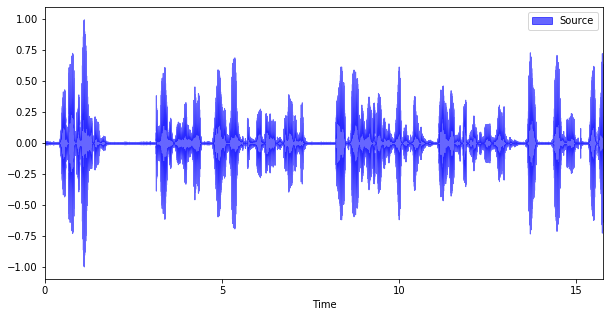

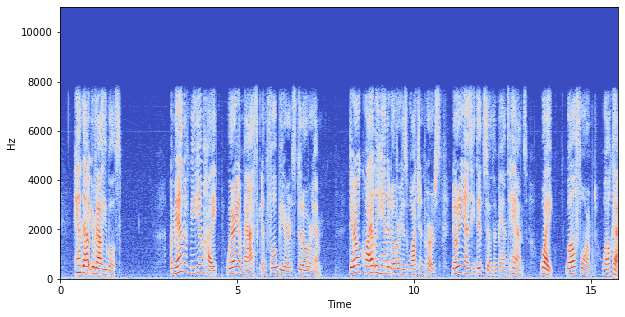

In [4]:
# Make sure source file is loading properly.
src_time = librosa.get_duration(filename=sFile_lst[0]) # <-- Only want to load a small amount of the file
y, sa_r = librosa.load(sFile_lst[1],duration=src_time) # <-- Loading file

#Plot wavefunction
plt.figure(figsize = (10,5))
librosa.display.waveplot(y, sa_r, color = 'blue', alpha = 0.6, label = 'Source')
plt.legend()

#Plot signal in 
plt.figure(figsize=(10,5))
src_ft = librosa.stft(y)
src_db = librosa.amplitude_to_db(abs(src_ft))
librosa.display.specshow(src_db, sr=sa_r, x_axis='time', y_axis='hz')
ipd.Audio(sFile_lst[1])

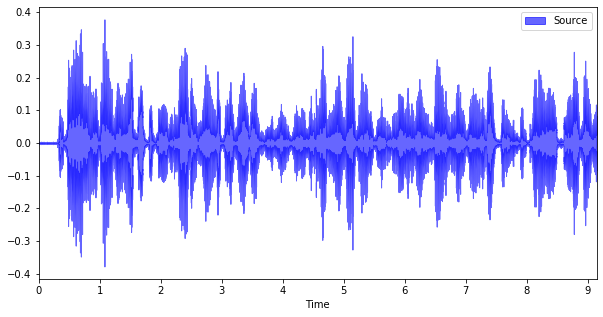

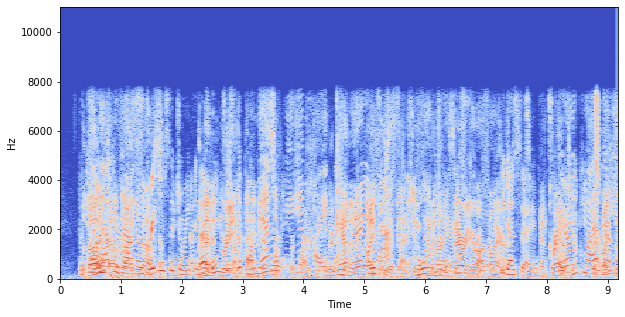

In [17]:
# Make sure source file is loading properly.
src_time = [librosa.get_duration(filename=sFile_lst[1]), librosa.get_duration(filename=sFile_lst[500]),librosa.get_duration(filename=sFile_lst[200]),librosa.get_duration(filename=sFile_lst[1000])]
src_time = min(src_time)
y2, sa_r = librosa.load(sFile_lst[1000]) # <-- Loading file
y, sa_r = librosa.load(sFile_lst[1],duration=src_time)
y3, sa_r = librosa.load(sFile_lst[200],duration=src_time) # <-- Loading file
y4, sa_r = librosa.load(sFile_lst[500],duration=src_time) # <-- Loading file
new_y = (y2/8+y/8+y3/6+y4/2)
#Plot wavefunction
plt.figure(figsize = (10,5))
librosa.display.waveplot(new_y, sa_r, color = 'blue', alpha = 0.6, label = 'Source')
plt.legend()

#Plot signal in 
plt.figure(figsize=(10,5))
src_ft = librosa.stft(new_y)
src_db = librosa.amplitude_to_db(abs(src_ft))
librosa.display.specshow(src_db, sr=sa_r, x_axis='time', y_axis='hz')
ipd.Audio(new_y, rate=sa_r)

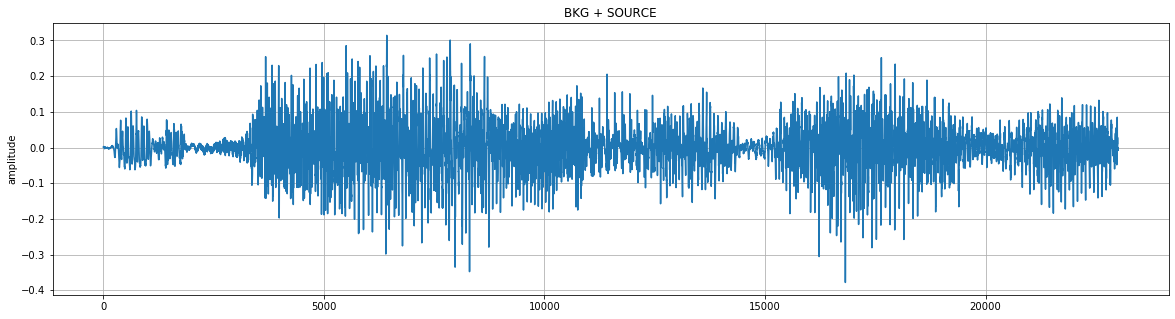

In [23]:
n0=7000
n1=30000
plt.figure(figsize=(20, 5))
plt.plot(new_y[n0:n1])
plt.title("BKG + SOURCE")
plt.ylabel("amplitude")
plt.grid()
plt.show()

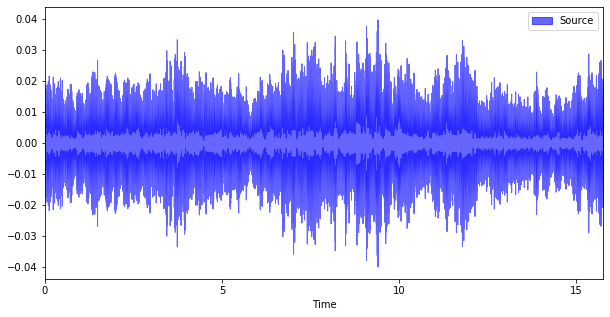

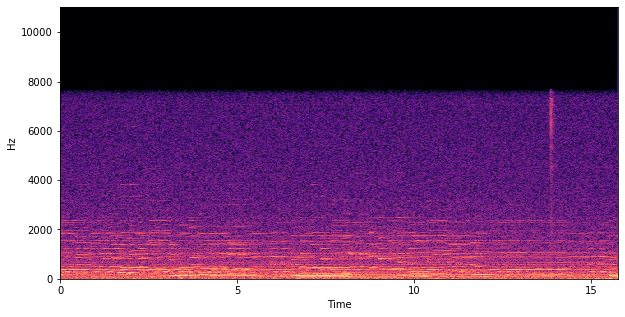

In [7]:
# Make sure bkg file is loading properly.
src_time = librosa.get_duration(filename=sFile_lst[0]) # <-- Only want to load a small amount of the file
y, sa_r = librosa.load(bFile_lst[1], duration=src_time) # <-- Loading file
#Plot wavefunction
plt.figure(figsize = (10,5))
librosa.display.waveplot(y, sa_r, color = 'blue', alpha = 0.6, label = 'Source')
plt.legend()

#Plot signal in 
plt.figure(figsize=(10,5))
src_ft = librosa.stft(y)
src_db = librosa.amplitude_to_db(abs(src_ft))
librosa.display.specshow(src_db, sr=sa_r, x_axis='time', y_axis='hz')
ipd.Audio(sFile_lst[1])

In [8]:
#### Obtaining Length of largest source file
def mx_len(filename):
    aud_mlen = 0
    f_name = ""
    for name in filename:
        f_len = librosa.get_duration(filename=name)
        if aud_mlen < f_len:
            aud_mlen = f_len
            f_name = name
    a_len, _ = librosa.load(f_name)
    a_len = len(a_len)  
    return a_len

In [9]:
# Make a list of speakers for each file ( Creating Labels )
def find_id(sfname):
    #Creating a list of speaker labels to be used as labels for the Deep Learning Model
    sspker_label = [name[name.find("-sp")+1:name.find("-ch")] for name in sfname]
    return sspker_label

In [10]:
# Creating list of path names to source file  
sf_lst = sFile_lst + hFile_lst 

mf_len = mx_len(sf_lst)

In [11]:
df_len = len(sf_lst) 
sf_lst = np.repeat(sf_lst,len(bFile_lst))

# Creating list of speaker ID for each file path
spkr_id = find_id(sf_lst)

# Creating list of bFiles the length of the other 
bkg_lst = bFile_lst * df_len

df = pd.DataFrame({'filePath': sf_lst,'bkg_noise': bkg_lst ,'spkr_id':spkr_id})

In [26]:
#Adding BKG noise and output file with pickle. <--- "I think this is redundant now"
def convert_to_file(df, max_len, train, class_lst):
    # Load signal file and load background file of length signal file from a random point in background file.
    # The background file is much larger than the signal file 55mins compared to ~ 15 seconds
    # Seed for random is set above to produce reproducable results.
    a_len = max_len
    f_out = {}
    a = []
    b = []
    for i in range(len(df)):
        src_x, src_sr = librosa.load(df['filePath'][i])

        src_len = librosa.get_duration(filename=df['filePath'][i])
        bkg_len = librosa.get_duration(filename=df['bkg_noise'][i])
        time_diff = bkg_len - src_len+1
        rand_time = random.uniform(0, time_diff)

        bkg_x, bkg_sr = librosa.load(df['bkg_noise'][i], offset=rand_time, duration=src_len)
        
        if len(bkg_x) > len(src_x):
            bkg_x = bkg_x[0:len(src_x)]
        elif len(bkg_x) < len(src_x):
            bkg_x = np.append(bkg_x, np.zeros(shape=(len(src_x)-len(bkg_x))))
            
        n_x = ((bkg_x*6)+src_x)/2 #<---- Lets try increasing the background by a factor of 6
        n_x = n_x.reshape(-1, 1)
        n_sr = ((src_sr+bkg_sr)/2)
        
        if len(n_x) < a_len:
            z = np.zeros(shape=(a_len-len(n_x), 1))
            n_x = np.concatenate((n_x, z))
        else:
            n_x = n_x[0:a_len]

        if train:
            out_file = './data/train.pkl'
        else:
            out_file = './data/test.pkl'
          
        a.append(np.where(class_lst == df['spkr_id'][i]))
        b.append(n_x)
        
    out = {'class_id': a,
           'audio': b}

    with open(out_file, 'wb') as w:
            pickle.dump(out, w)

In [27]:
# only when using pickle. <----------- This is redundant now
def get_data(filename):
    x ,y = [], [] 
    with open(filename,'rb') as f:
        data = pickle.load(f)
      #  print(data['audio'].shape)
        x.append(data['audio'])
        y.append(data['class_id'])   
    y=np.array(y).reshape(-1,1)
    return np.array(x), np.array(y)

In [12]:
#Adding BKG noise without output file
def create_data(df, max_len, train, class_lst):
    # Load signal file and load background file of length signal file from a random point in background file.
    # The background file is much larger than the signal file 55mins compared to ~ 15 seconds
    # Seed for random is set above to produce reproducable results.
    a_len = max_len
    f_out = {}
    a = []
    b = []

    for i in range(len(df)):
        src_x, src_sr = librosa.load(df['filePath'][i])

        src_len = librosa.get_duration(filename=df['filePath'][i])
        bkg_len = librosa.get_duration(filename=df['bkg_noise'][i])
        time_diff = bkg_len - src_len+1
        rand_time = random.uniform(0, time_diff)

        bkg_x, bkg_sr = librosa.load(df['bkg_noise'][i], offset=rand_time, duration=src_len)
        
        if len(bkg_x) > len(src_x):
            bkg_x = bkg_x[0:len(src_x)]
        elif len(bkg_x) < len(src_x):
            bkg_x = np.append(bkg_x, np.zeros(shape=(len(src_x)-len(bkg_x))))
            
        n_x = ((bkg_x*6)+src_x)/2 #<---- Lets try increasing the background by a factor of 6
        n_x = n_x.reshape(-1, 1)
        n_sr = ((src_sr+bkg_sr)/2)
        
        if len(n_x) < a_len:
            z = np.zeros(shape=(a_len-len(n_x), 1))
            n_x = np.concatenate((n_x, z))
        else:
            n_x = n_x[0:a_len]

          
        b.append(np.where(class_lst == df['spkr_id'][i]))
        a.append(n_x)
        
    return np.array(a), np.array(b)

In [12]:
#Loading Audio Files in batches 

def load_data(df, shape, batchsize=32):
    
    x, y = create_data(df)
    return x, y
    

In [13]:
#Splitting testing and training
#For actual 
#df = df.sample(frac=1, random_state=123).reset_index(drop=True) #<---- Shuffle the dataframe
#For testing

df = df[0:2]
df = df.sample(frac=1, random_state=123).reset_index(drop=True) #<---- Shuffle the dataframe
tr_df = df[0:int(len(df)*0.8)]
te_df = df[int(len(df)*0.8):].reset_index()
num_classes = len(tr_df['spkr_id'].unique())
classes = tr_df['spkr_id'].unique()

In [14]:
print(num_classes)
print(len(tr_df))
print(classes)
#y = 'sp0208'

#index = np.where(classes== y)
#index[0][0]

1
1
['sp4057']


In [ ]:
random.seed(212)
convert_data(tr_df, mf_len, True, classes)

In [ ]:
convert_data(te_df, mf_len, False, classes)

In [15]:
tr_x ,tr_y = create_data(tr_df, mf_len, True, classes)
val_x ,val_y = create_data(te_df, mf_len, False, classes)

In [17]:
# ONLY RUN THIS CELL IF YOU USED CONVERT 1
# ELSE NO NEED TO RUN 
#train_pkl = "./data/train.pkl"
#val_pkl = './data/test.pkl'

#tr_x ,tr_y = get_data(train_pkl)
#val_x ,val_y = get_data(val_pkl)
tr_x.shape


(1, 708798, 1)

In [18]:
def to_bin(y):
    hold_val_y = []
    for i in range(len(y)):
        #hold_val_y.append(bin(val_y[i][0]).format(1))
        hold_val_y.append([0.,int(bin(y[i][0])[2:])])
    a = np.array(hold_val_y).reshape(1,-1,2)
    return(a)

In [19]:
ntr_y = to_bin(tr_y[0])
nval_y = to_bin(val_y[0])

In [20]:
ntr_y.shape

(1, 1, 2)

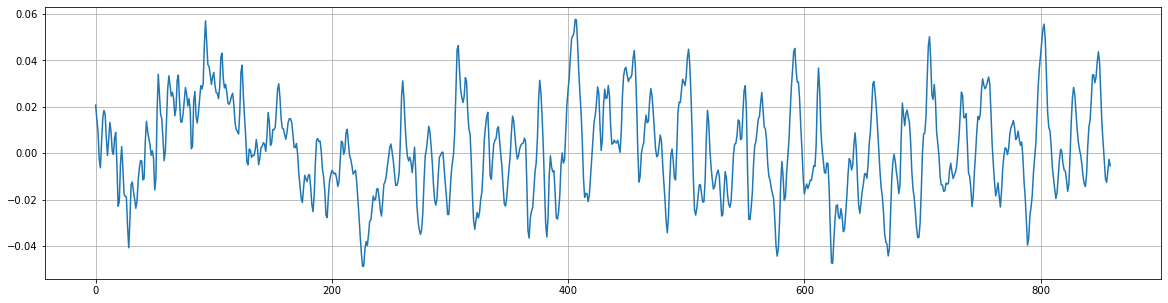

In [23]:
n0 = 140
n1 = 1000
plt.figure(figsize=(20, 5))
plt.plot(tr_x[0][n0:n1])
plt.grid()

In [24]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling1D , Flatten, Conv1D, Activation

def model_SR(num_classes, aud_len):
    filters = 128
    m = Sequential()
    m.add(Conv1D(filters, kernel_size =70, input_shape=(aud_len, 1), strides=4))
  #  m.add(Activation('relu'))
    m.add(MaxPooling1D(pool_size=16))
    m.add(Conv1D(filters, kernel_size =70))
    m.add(BatchNormalization())
    m.add(Activation('relu'))
    m.add(MaxPooling1D(pool_size=4))
    
    #m.add(Conv1D(filters, kernel_size = 30, padding='same'))
    #m.add(MaxPooling1D(pool_size=4))   
    m.add(Flatten())
    m.add(Dense(64, activation='relu'))
    m.add(Dense(num_classes, activation='softmax'))
    
    return m

In [25]:
model = model_SR(num_classes, mf_len)
                                    
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 177183, 128)       9088      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11073, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11004, 128)        1147008   
_________________________________________________________________
batch_normalization (BatchNo (None, 11004, 128)        512       
_________________________________________________________________
activation (Activation)      (None, 11004, 128)        0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2751, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 352128)            0

In [26]:
print(tr_x[0][0].shape)

(1,)


In [27]:
#from tensorflow.keras.utils import to_categorical
#tr_y = to_categorical(tr_y)
#val_x = to_categorical(val_x)

In [ ]:
history = model.fit(x=tr_x, y=ntr_y, 
                epochs=2, 
                batch_size=200, 
                validation_data=(val_x, nval_y),
                shuffle=True)

Train on 1 samples, validate on 1 samples
Epoch 1/2


In [17]:
count = 0
def count_up(count):
    count+=1 
    return count
    

In [24]:
count = count_up(count)

In [25]:
print(count)

3
